In [48]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

import os

from xception import Xception
from EmbryoDataset import EmbryoDataset

In [42]:
df_train = pd.read_csv('./data/train.csv')
df_train.head()

,Image,Class
0,D3_405.jpg,0
1,D3_523.jpg,0
2,D3_750.jpg,0
3,D3_427.jpg,0
4,D3_042.jpg,0


Let's see how is the label distribution in our dataset:

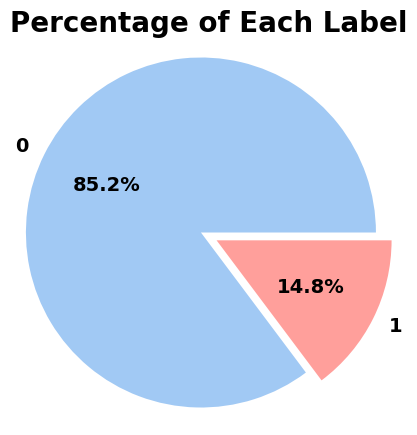

In [43]:
# define Seaborn color palette to use
palette_color = sns.color_palette('pastel')
label_counts = df_train['Class'].value_counts()

# plotting data on chart
plt.figure(figsize=(5, 5))
plt.pie(label_counts, labels=label_counts.index, colors=[palette_color[0], palette_color[3]], explode=[0, 0.1], autopct='%1.1f%%', textprops={'fontsize': 14, 'fontweight': 'bold'})

plt.title('Percentage of Each Label', fontsize=20, fontweight='bold')
plt.axis('equal')
plt.show()

We can see that our dataset is imbalanced and we need to consider this imbalancy in our analysis. We are going to attribute some weights to each label and use these weights in our loss function.

In [26]:
class_weight = 1 - (label_counts / df_train.shape[0])
class_weight = list(class_weight)

In [27]:
df_test = pd.read_csv('./data/test.csv')
df_test.head()

,ID,Image
0,1,D3_693.jpg
1,2,D3_212.jpg
2,3,D3_724.jpg
3,4,D3_623.jpg
4,5,D3_210.jpg


Let's plot one good and one not good embryo images:

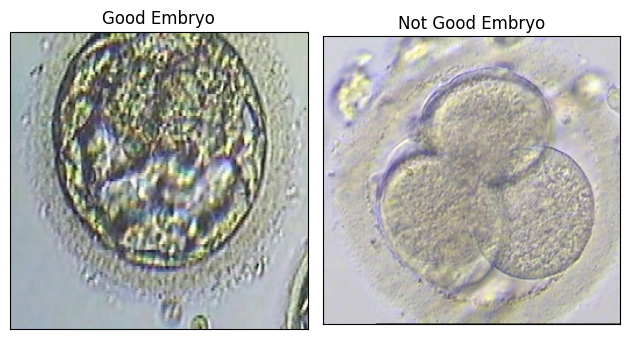

In [28]:
# Filter images based on class
good_images = df_train[df_train['Class'] == 1]['Image'].tolist()
not_good_images = df_train[df_train['Class'] == 0]['Image'].tolist()

# Randomly select one image from each class
random_good_image = random.choice(good_images)
random_not_good_image = random.choice(not_good_images)

random_good_image = './data/train/' + random_good_image
random_not_good_image = './data/train/' + random_not_good_image

# Plotting randomly selected images
fig, axes = plt.subplots(1, 2)

# Plot random good image
img = plt.imread(random_good_image)
axes[0].imshow(img)
axes[0].set_title('Good Embryo')

axes[0].set_xticks([])  # Remove xticks
axes[0].set_yticks([])  # Remove yticks

# Plot random not good image
img = plt.imread(random_not_good_image)
axes[1].imshow(img)
axes[1].set_title('Not Good Embryo')

axes[1].set_xticks([])  # Remove xticks
axes[1].set_yticks([])  # Remove yticks

plt.tight_layout()
plt.show()

In [29]:
train_data_path = './data/train'
test_data_path = './data/test'

# create the train_image_label_mapping
train_image_label_mapping = {}

for filename in os.listdir(train_data_path):
    train_image_label_mapping[train_data_path + '/' + filename] = df_train[df_train['Image'] == filename]['Class'].values[0]


# create the test_image_label_mapping
test_image_label_mapping = {}

for filename in os.listdir(test_data_path):
    test_image_label_mapping[test_data_path + '/' + filename] = df_test[df_test['Image'] == filename]['ID'].values[0]

In [20]:
# defining the tranformations for the input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [30]:
# set up the dataset
train_data = EmbryoDataset(train_image_label_mapping, transform=transform)
test_data = EmbryoDataset(test_image_label_mapping, train=False, transform=transform)

In [32]:
# Spliting train data to train and validation parts
valid_size = 0.2
dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(valid_size * dataset_size))
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

# Generating dataloaders
train_loader = DataLoader(train_data, batch_size=4, num_workers=2, sampler=train_sampler, pin_memory=True)
valid_loader = DataLoader(train_data, batch_size=4, num_workers=2, sampler=valid_sampler, pin_memory=True)

# test dataloader
test_loader = DataLoader(test_data, shuffle=False, num_workers=2)

In [49]:
# Get cpu or gpu
device = ('cuda' if torch.cuda.is_available() else 'cpu')
# print(f'Using {device} device')

# define the model and use pretrained weights
xception = Xception()
xception.load_state_dict(torch.load('./xception-43020ad28.pth'))

# change the number of output classes
num_ftrs = xception.fc.in_features
xception.fc = nn.Linear(num_ftrs, 2)

xception = xception.to(device)
# print(xception)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/xception-43020ad28.pth" to /Users/sabacharmimotlagh/.cache/torch/hub/checkpoints/xception-43020ad28.pth


URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)>

In [36]:
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(class_weight)).cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(xception.parameters(), lr=1e-3, weight_decay=1e-5)

In [38]:
def train_one_epoch(dataloader, model, criterion, optimizer):

    train_loss = 0.0
    size = len(dataloader.sampler)
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = criterion(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    return train_loss

In [39]:
epochs = 20
min_valid_loss = np.inf

for epoch in range(epochs):

    train_loss = train_one_epoch(train_loader, xception, criterion, optimizer)

    valid_loss = 0.0
    xception.eval()

    with torch.no_grad():
        for X, y in valid_loader:
            X, y = X.to(device), y.to(device)

            pred = xception(X)
            loss = criterion(pred, y)

            valid_loss += loss.item()

    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader.sampler)} \t\t Validation Loss: {valid_loss / len(valid_loader.sampler)}')
    if min_valid_loss > valid_loss:
        min_valid_loss = valid_loss

        print('Saving..')
        state = {
                'net': xception.state_dict(),
            }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
            
        torch.save(state, './checkpoint/ckpt.pth')

KeyboardInterrupt: 

In [23]:
best_model = xception()
best_model.load_state_dict(torch.load('./checkpoint/ckpt.pth')['net'])
preds = {}

with torch.no_grad():
    for X, id in test_loader:
        X = X.to(device)
        pred = best_model(X).argmax(1)


        preds[id.item()] = pred.item()

In [24]:
df_preds = pd.DataFrame.from_dict(preds, orient='index', columns=['Class']).sort_index().reset_index().rename(columns={'index': 'ID'})
df_preds

,ID,Class
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
175,176,1
176,177,0
177,178,1
178,179,0
